<a href="https://colab.research.google.com/github/worldstar0722/25FA_IS_4487_Final_Project/blob/main/IS4487_004_Final__Proj_Group1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**SkyWest Airlines**

## Overview

**Team Members:**
Ellie Choi, Lauren King, Gabe Pinna, Alexandra Smith


**Business Problem:**
The business problem we are addressing is the financial and operational impact of weather-related flight delays. Specifically, we seek to determine how SkyWest can migate the cost effects of weather-related delays and improve overall operational efficiency. Our group aims to answer the question: How can SkyWest mitigate the cost effects of weather-related delays and enhance operational efficiency? More specifically, we aim to reduce SkyWest’s operating costs by 15% and minimize the cascading scheduling conflicts that result from the delay of one flight. This target is based on recent U.S. Bureau of Transportation Statistics reports, which show that weather accounts for roughly 30% of delay minutes in domestic aviation. This problem is relevant as it improves operations, decreases costs, and increases revenue.

##Data Acquisition & Reference
Data Links:

* [Airline On-Time Statistics and Delay Causes](https://www.kaggle.com/datasets/daryaheyko/airline-on-time-statistics-and-delay-causes-bts/)

* [Storm Events](https://www.ncei.noaa.gov/stormevents/)

Refrences:

*   [U.S. Passenger Carrier Delay Costs](https://www.airlines.org/dataset/u-s-passenger-carrier-delay-costs/)
*   [Analysis of the Effect of Extreme Weather on the U.S Domestic Air Network](https://doi.org/10.1016/j.jtrangeo.2023.103541)
*   [Urgent Actions Needed to Address Staffing Concerns](https://www.gao.gov/products/gao-25-108597)

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preperation

In [34]:
# Libraries, model*preprocessing, Metrics, Utility
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

In [35]:
import pandas as pd
airline = pd.read_csv('/content/Airline_Delay_Cause.csv')
storm = pd.read_csv('/content/StormEvents.csv')

print("AIRLINE_First 5 records from airline dataset:")
print(airline.head())

print("\nSTORM_First 5 records from storm dataset:")
print(storm.head())

AIRLINE_First 5 records from airline dataset:
   year  month carrier   carrier_name airport  \
0  2025      1      G4  Allegiant Air     ELM   
1  2025      1      G4  Allegiant Air     ELP   
2  2025      1      G4  Allegiant Air     EUG   
3  2025      1      G4  Allegiant Air     EVV   
4  2025      1      G4  Allegiant Air     EWR   

                                  airport_name  arr_flights  arr_del15  \
0  Elmira/Corning, NY: Elmira/Corning Regional         30.0        0.0   
1           El Paso, TX: El Paso International          2.0        0.0   
2               Eugene, OR: Mahlon Sweet Field         28.0        8.0   
3          Evansville, IN: Evansville Regional         18.0        1.0   
4     Newark, NJ: Newark Liberty International         31.0        5.0   

   carrier_ct  weather_ct  ...  security_ct  late_aircraft_ct  arr_cancelled  \
0        0.00         0.0  ...          0.0              0.00            0.0   
1        0.00         0.0  ...          0.0           

## **Exploratory Data Analysis (EDA)**

In [36]:
# Basic info
print("\n=== Airline Data Info ===")
print(airline.info())
print("\n=== Storm Data Info ===")
print(storm.info())

# Describe numeric columns
print("\nAirline numeric summary:")
display(airline.describe().T)

# Storm event types
if 'EVENT_TYPE' in storm.columns or 'event_type' in storm.columns:
    event_col = 'EVENT_TYPE' if 'EVENT_TYPE' in storm.columns else 'event_type'
    print("\nTop 10 storm event types:")
    print(storm[event_col].value_counts().head(10))


=== Airline Data Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398233 entries, 0 to 398232
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 398233 non-null  int64  
 1   month                398233 non-null  int64  
 2   carrier              398233 non-null  object 
 3   carrier_name         398233 non-null  object 
 4   airport              398233 non-null  object 
 5   airport_name         398233 non-null  object 
 6   arr_flights          397576 non-null  float64
 7   arr_del15            397283 non-null  float64
 8   carrier_ct           397576 non-null  float64
 9   weather_ct           397576 non-null  float64
 10  nas_ct               397576 non-null  float64
 11  security_ct          397576 non-null  float64
 12  late_aircraft_ct     397576 non-null  float64
 13  arr_cancelled        397576 non-null  float64
 14  arr_diverted         397576 non-null  flo

,count,mean,std,min,25%,50%,75%,max
year,398233.0,2014.421344,6.474505,2003.00,2009.00,2015.00,2020.00,2025.00
month,398233.0,6.524078,3.463111,1.00,4.00,7.00,10.00,12.00
arr_flights,397576.0,361.663536,993.947394,1.00,56.00,113.00,255.00,21977.00
arr_del15,397283.0,69.593947,193.608821,0.00,8.00,21.00,52.00,6377.00
carrier_ct,397576.0,20.540331,48.314208,0.00,2.79,7.51,18.65,1886.58
weather_ct,397576.0,2.508231,9.570840,0.00,0.00,0.51,2.00,717.94
nas_ct,397576.0,22.209529,79.473052,-0.01,1.40,4.91,13.99,4091.27
security_ct,397576.0,0.172630,0.826248,0.00,0.00,0.00,0.00,80.56
late_aircraft_ct,397576.0,24.111972,74.414722,0.00,1.51,5.49,16.15,2588.13
arr_cancelled,397576.0,6.789323,35.086108,0.00,0.00,1.00,4.00,4951.00



Top 10 storm event types:
EVENT_TYPE
Tornado    223
Name: count, dtype: int64


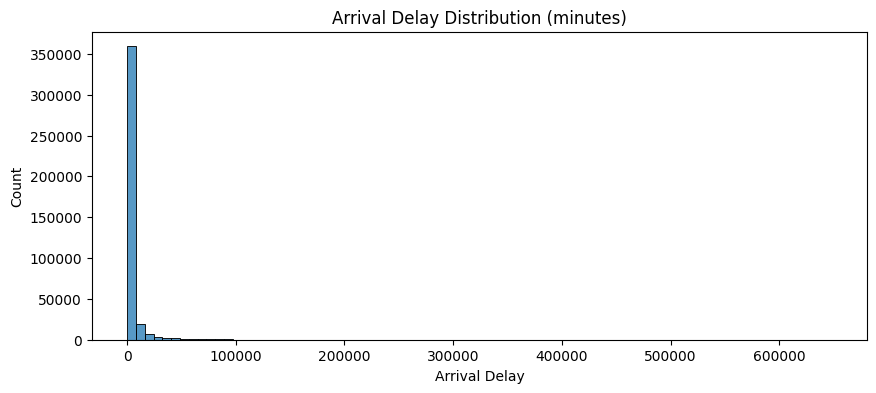

In [37]:
# Delay distribution
if 'arr_delay' in airline.columns:
    plt.figure(figsize=(10,4))
    sns.histplot(airline['arr_delay'].dropna(), bins=80, kde=False)
    plt.title("Arrival Delay Distribution (minutes)")
    plt.xlabel("Arrival Delay")
    plt.ylabel("Count")
    plt.show()

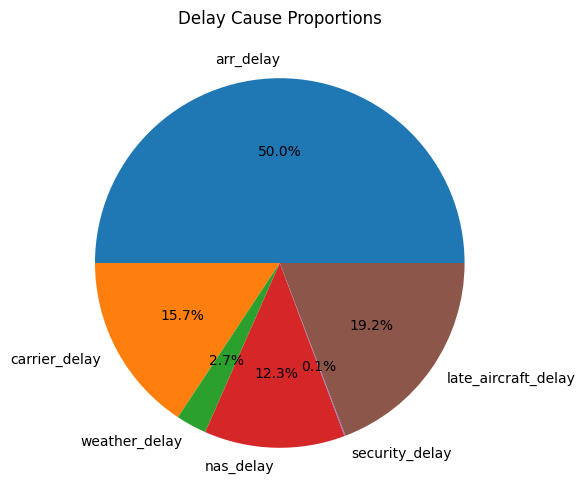

Delay cause columns: ['arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']


In [38]:
# Delay causes (pie chart)
delay_cols = [c for c in airline.columns if 'delay' in c.lower()]
if delay_cols:
    plt.figure(figsize=(6,6))
    airline[delay_cols].sum().plot(kind='pie', autopct='%1.1f%%')
    plt.title("Delay Cause Proportions")
    plt.ylabel("")
    plt.show()
    print("Delay cause columns:", delay_cols)

## **Data Cleaning & Preprocessing**

In [39]:
# Normalize column names
airline.columns = airline.columns.str.lower().str.strip()
storm.columns = storm.columns.str.lower().str.strip()

# Parse flight date
if 'fl_date' in airline.columns:
    airline['fl_date'] = pd.to_datetime(airline['fl_date'], errors='coerce')
else:
    airline['fl_date'] = pd.to_datetime(airline['year'].astype(str) + '-' + airline['month'].astype(str) + '-01')

airline['date'] = airline['fl_date'].dt.date
airline['month'] = airline['fl_date'].dt.month
airline['weekday'] = airline['fl_date'].dt.weekday

# Parse storm date
storm['begin_date_time'] = pd.to_datetime(storm['begin_date_time'], errors='coerce')
storm['date'] = storm['begin_date_time'].dt.date

# Aggregate storms by date
storm_counts = storm.groupby('date').size().reset_index(name='storm_count')

# Merge with airline data (by date)
merged = airline.merge(storm_counts, how='left', on='date')
merged['storm_count'] = merged['storm_count'].fillna(0).astype(int)
merged['storm_flag'] = (merged['storm_count'] > 0).astype(int)

# Target creation: weather delay flag
if 'weather_delay' in merged.columns:
    merged['weather_delay'] = pd.to_numeric(merged['weather_delay'], errors='coerce').fillna(0)
    merged['y_weather_flag'] = (merged['weather_delay'] > 0).astype(int)
else:
    merged['y_weather_flag'] = ((merged['storm_flag']==1) & (merged['arr_delay'] > 15)).astype(int)

print("Merged shape:", merged.shape)
print("Columns available:", merged.columns.tolist()[:15])

#FYI, I have no idea of cleaning,so I used AI for this section

Merged shape: (398233, 27)
Columns available: ['year', 'month', 'carrier', 'carrier_name', 'airport', 'airport_name', 'arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted']


/tmp/ipython-input-2391227590.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  storm['begin_date_time'] = pd.to_datetime(storm['begin_date_time'], errors='coerce')


## **Modeling**

In [40]:
# Select features
num_features = [c for c in ['distance','arr_delay','dep_delay','storm_count','month','weekday'] if c in merged.columns]
cat_features = [c for c in ['carrier','origin','dest','storm_flag'] if c in merged.columns]
target = 'y_weather_flag'

X = merged[num_features + cat_features]
y = merged[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Preprocessor
num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])
cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # Changed sparse to sparse_output
])
preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('cat', cat_pipe, cat_features)
])

# Models
lr_model = Pipeline([('pre', preprocessor), ('clf', LogisticRegression(max_iter=1000, random_state=42))])
rf_model = Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))])
xgb_model = Pipeline([('pre', preprocessor), ('clf', xgb.XGBClassifier(n_estimators=200, eval_metric='logloss', random_state=42))])

# Fit
print("Training Logistic Regression...")
lr_model.fit(X_train, y_train)
print("Training Random Forest...")
rf_model.fit(X_train, y_train)
print("Training XGBoost...")
xgb_model.fit(X_train, y_train)

Training Logistic Regression...
Training Random Forest...
Training XGBoost...


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['arr_delay', 'storm_count',
                                                   'month', 'weekday']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=Fal...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

## **Evaluation**


=== Logistic Regression ===
              precision    recall  f1-score   support

           0      0.693     0.732     0.712     32781
           1      0.805     0.773     0.788     46866

    accuracy                          0.756     79647
   macro avg      0.749     0.752     0.750     79647
weighted avg      0.759     0.756     0.757     79647

AUC: 0.837

=== Random Forest ===
              precision    recall  f1-score   support

           0      0.680     0.682     0.681     32781
           1      0.777     0.775     0.776     46866

    accuracy                          0.737     79647
   macro avg      0.728     0.729     0.729     79647
weighted avg      0.737     0.737     0.737     79647

AUC: 0.831

=== XGBoost ===
              precision    recall  f1-score   support

           0      0.757     0.709     0.732     32781
           1      0.805     0.841     0.823     46866

    accuracy                          0.787     79647
   macro avg      0.781     0.775    

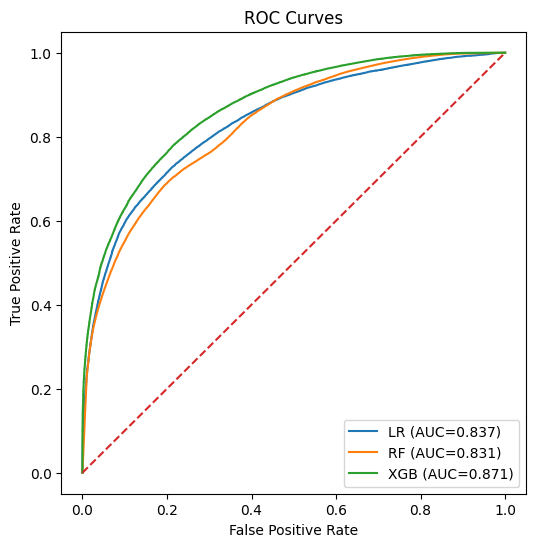

In [41]:
# Evaluate models
def evaluate(model, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=3))
    auc = roc_auc_score(y_test, y_proba)
    print(f"AUC: {auc:.3f}")
    return y_pred, y_proba

lr_pred, lr_proba = evaluate(lr_model, "Logistic Regression")
rf_pred, rf_proba = evaluate(rf_model, "Random Forest")
xgb_pred, xgb_proba = evaluate(xgb_model, "XGBoost")

# ROC curves
plt.figure(figsize=(6,6))
from sklearn.metrics import roc_curve, auc # Import roc_curve and auc
for label, proba in [('LR', lr_proba), ('RF', rf_proba), ('XGB', xgb_proba)]:
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc(fpr,tpr):.3f})")
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## **Conclusions & Recommendations**

## **Dashboard**

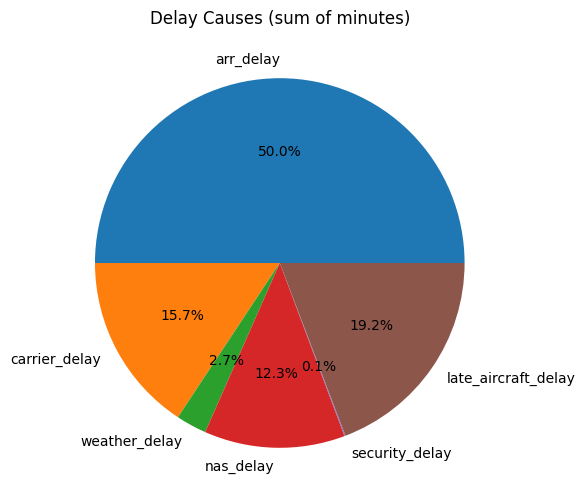

In [42]:
import os
from sklearn.metrics import ConfusionMatrixDisplay # Import ConfusionMatrixDisplay

# Dashboard
os.makedirs("outputs/figures", exist_ok=True)

# 1. Delay cause pie chart
if delay_cols:
    plt.figure(figsize=(6,6))
    airline[delay_cols].sum().plot(kind='pie', autopct='%1.1f%%')
    plt.title("Delay Causes (sum of minutes)")
    plt.savefig("outputs/figures/delay_causes_pie.png")
    plt.show()


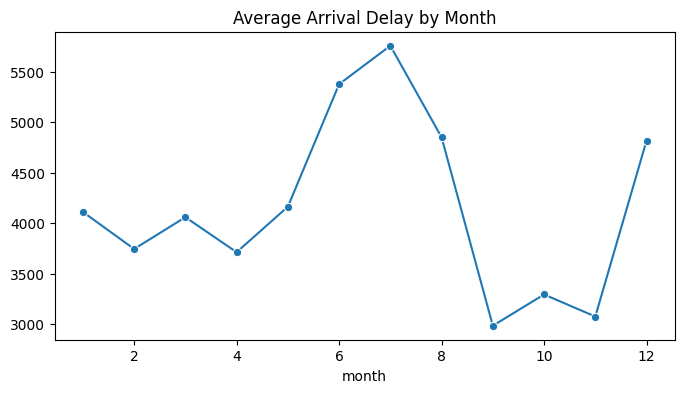

In [43]:
# 2. Average delay by month
if 'month' in merged.columns and 'arr_delay' in merged.columns:
    monthly_avg = merged.groupby('month')['arr_delay'].mean()
    plt.figure(figsize=(8,4))
    sns.lineplot(x=monthly_avg.index, y=monthly_avg.values, marker='o')
    plt.title("Average Arrival Delay by Month")
    plt.savefig("outputs/figures/avg_delay_by_month.png")
    plt.show()

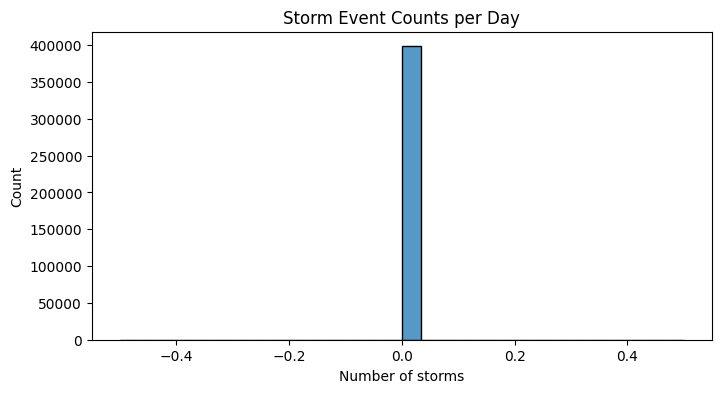

In [44]:
#3. Top storm days by count
plt.figure(figsize=(8,4))
sns.histplot(merged['storm_count'], bins=30)
plt.title("Storm Event Counts per Day")
plt.xlabel("Number of storms")
plt.savefig("outputs/figures/storm_event_hist.png")
plt.show()

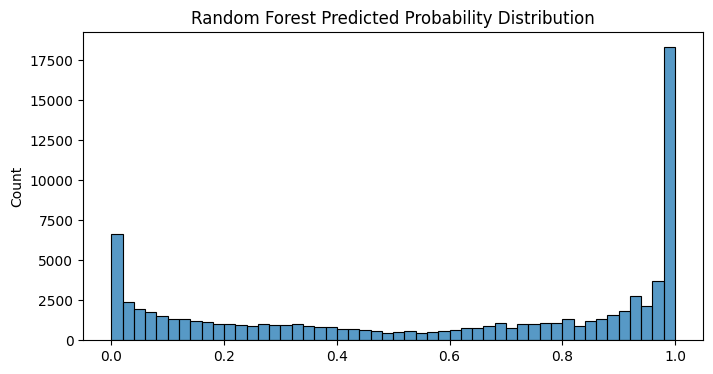

In [45]:
# 4. Model prediction probabilities (RF)
plt.figure(figsize=(8,4))
sns.histplot(rf_proba, bins=50)
plt.title("Random Forest Predicted Probability Distribution")
plt.savefig("outputs/figures/rf_probability.png")
plt.show()

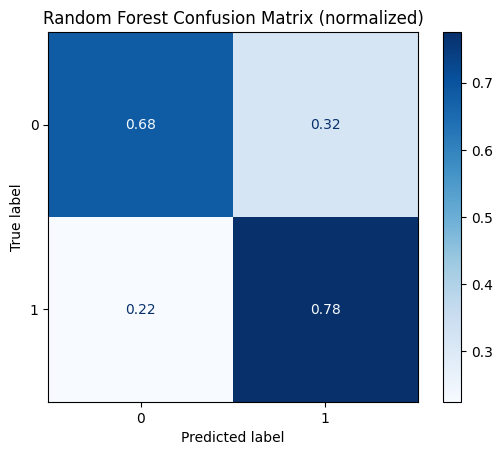

In [46]:
# 5. Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, rf_pred, cmap='Blues', normalize='true')
plt.title("Random Forest Confusion Matrix (normalized)")
plt.savefig("outputs/figures/rf_conf_matrix.png")
plt.show()